# Pi Filter

![Pi filter schematic](Pi-Filter.png){#fig-pi-filter}  

## Introduction
A question posted on [Electronics Stackexchange](https://electronics.stackexchange.com/questions/681002/how-to-find-transfer-function-for-this-pi-filter-using-facts-method-with-6-react/681087#681087) by @user15174 looked interesting, he asked: 

>Am trying to apply the FACTS method to find out the transfer function for this circuit as shown below. This is a Pi-filter circuit with all its component parasitics and also including the source and load resistances. I would like to find out the transfer function of this circuit and match its plot from Mathcad with simulation.

>First, to find out the zeros of the this transfer function by inspection, I placed all circuit elements in its high frequency state. I can observe the response Vout is still present. In that case, can I assume that this circuit has 6 zeros associated with it?

>But as per the answer provided in this link, we have to place the other associated circuit element in its DC state and observe if the response is still present. Since this circuit has around 6 reactive elements, how do I decide which circuit element should be in DC State and which circuit element should be in high frequency state?

>I was able to follow some examples done based on 2nd and 3rd order circuits shared in the above links. But with this circuit configuration and so many reactive elements, frankly am lost.
It would be great if you could share some insight on how to derive the transfer function for this circuit including its poles and zeros.

The FACTS (Fast Analytical Circuits Techniques) method refers to a circuit analysis technique that enables engineers to obtain the transfer functions and input and output impedances of a circuit by inspection without resorting to too much algebra. The circuits offered as illustrations of the technique are small with one or two branches. I was able to find several references on-line describing the FACTS method. 

@Middlebrook1991 seems to have been the first proponent of the method and describes what he calls design orientated analysis. He talks about low entropy equations, in which the terms and elements are ordered or grouped in such a way that their physical orgin, where they come from in the circuit, what part of the circuit contributes to this part of the final expression becomes obious. The method is also described in @Middlebrook1992. 

@basso2016 introduces the topic at a conference and has written a book on the subject. The method involves looking at time constants for branches with L's or C's. The advantage is that only pencil and paper are needed. 

## Community answers
There were two answers provided by the community. User @user347817 provided a detailed solution based on reducing the circuit to Z1, Z2 and Z3 as shown in @fig-pi-filter-franc and then substituting back into the transfer function the impedances for each of the Z's. User Telsa23 provided a shorter answer, also based on reducing the circuit to Z1, Z2 and Z3, but where a different expression for the transfer function was obtained. Neither of these answers follow the FACTS method.

## Circuit description
@fig-pi-filter shows the schematic as I re-drew it in LTSpice with all the values set to one. I numbered each of the nodes and made some changes to the reference designators. In the orginal question, no component values were provided. @user15174 stated that component parasitics are inclued, but he didn't indicate which circuit elements he considered parasitic. I'm going to consider C1, L3 and C2 as the main components of the Pi-Filter. $R_{in}$ and $R_{out}$ are the source and load impedances. All other elements in the schematic are parasitic and the values will be assigned later in the analysis.
 
With C1, L3 and C2 being considerd as the main components, the circuit is a three section low pass filter, sometimes called a Pi filter because the connection represent the greek letter $\pi$. The schematic in @fig-pi-filter has 13 branches and 8 nodes.  

## Circuit analysis
@user15174 asked for a FACTS analysis. However, I think the circuit is too complicated for a FACTS analsysis since this is a 6th order circuit. Following my review of FACTS, I present a 'brute force' analysis followed by a rework of @user347817's solution. A MNA of the filter with the parasitic components removed is presented. This is a third order circuit and SymPy can obtain solutions for the poles of the transfer function. 

## FACTS
FACTS is a circuit analysis method where the transfer function is determined by some simple techniques and the poles and zeros of the transfer function are relatable to parts of the circuit and thereby some insight is gained into the operation of the circuit. The FACTS technique does take some practice and proficiency to master. The main advantage seems to be is the analysis technique can be quickly done without using a computer to find the DC gain of the network, the time constants of the  poles and zeros which can be directly written out as the system transfer function. The examples available on line use simple circuits of low order. Presummanlbly more detailed and complicated examples are available in @basso2016 and @Vorpérian2020.

According to the open source FACTS liturature:

>The well-known and widely used methods of nodal or loop analysis, while effective for obtaining numerical solutions, are largely ineffective for deriving analytical solutions in symbolic form, except for simple circuits. Attempting to invert a matrix with symbolic entries, even for low-order matrices, results in tedious algebra and complex, high-entropy expressions that provide little meaningful insight.

I don't agree with this assurtion. Simple circiuts are easily analyzied by hand or by inspection. Second order and lower lower circuits are ameaniable to FACTS or traditional nodal analysis, and I don't see the advantage of learning a new technique, which is limited to simple circuits. Symbolic MNA can easily handle higher order circuits beyond 2nd order. 

The circuit in question is a 6th order network and much too difficult to analysze by hand or with the FACTS method. 

FACTS procedure for determining a transfer function

1. Identify the circuit's order
2. Determine the DC Gain
3. Find the Time Constants
4. Identify the Zeros
5. Form the Transfer Function
6. Verification - It's recommended to use simulation tools like SPICE or mathematical software like Mathcad to verify the derived transfer function and ensure its accuracy

I think the key to successfully using the FACTS method is to apply low order circuits where some an analyitical expression is desired. But the symbolic MNA code presented in this notebook can easily yeild simular results without learing a new technique. 

## 'Brute Force' MNA procedure
Doing a so called brute force analysis. The goal is to get the transfer function, $H(s)=\frac {V_2}{V_8}$ and the poles and zeros of $H(s)$. SymPy will be used to 'brute force' analyze the circuit and solve for the transfer function and find the poles and zeros. 

The net list for the filter is:
```
V1 8 0 1
R_in 1 8 1
R1 1 4 1
Ra 3 1 1
R2 2 3 1
R3 2 6 1
R_out 2 0 1
L1 4 5 1 Rser=0
L2 3 2 1 Rser=0
L3 6 7 1 Rser=0
C1 5 0 1
C2 2 3 1
C3 7 0 1
```

The following Python modules are used in this notebook.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

Load the netlist generated from @fig-pi-filter.

In [2]:
net_list = '''
V1 8 0 1
R_in 1 8 1
R1 1 4 1
Ra 3 1 1
R2 2 3 1
R3 2 6 1
R_out 2 0 1
L1 4 5 1 
L2 3 2 1 
L3 6 7 1
C1 5 0 1
C2 2 3 1
C3 7 0 1
'''

Generate the network equations.

In [3]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# generate markdown text to display the network equations.
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$v_{1} \cdot \left(\frac{1}{Ra} + \frac{1}{R_{in}} + \frac{1}{R_{1}}\right) - \frac{v_{3}}{Ra} - \frac{v_{8}}{R_{in}} - \frac{v_{4}}{R_{1}} = 0$<br>$- I_{L2} + v_{2} \left(C_{2} s + \frac{1}{R_{out}} + \frac{1}{R_{3}} + \frac{1}{R_{2}}\right) + v_{3} \left(- C_{2} s - \frac{1}{R_{2}}\right) - \frac{v_{6}}{R_{3}} = 0$<br>$I_{L2} + v_{2} \left(- C_{2} s - \frac{1}{R_{2}}\right) + v_{3} \left(C_{2} s + \frac{1}{Ra} + \frac{1}{R_{2}}\right) - \frac{v_{1}}{Ra} = 0$<br>$I_{L1} - \frac{v_{1}}{R_{1}} + \frac{v_{4}}{R_{1}} = 0$<br>$C_{1} s v_{5} - I_{L1} = 0$<br>$I_{L3} - \frac{v_{2}}{R_{3}} + \frac{v_{6}}{R_{3}} = 0$<br>$C_{3} s v_{7} - I_{L3} = 0$<br>$I_{V1} - \frac{v_{1}}{R_{in}} + \frac{v_{8}}{R_{in}} = 0$<br>$v_{8} = V_{1}$<br>$- I_{L1} L_{1} s + v_{4} - v_{5} = 0$<br>$- I_{L2} L_{2} s - v_{2} + v_{3} = 0$<br>$- I_{L3} L_{3} s + v_{6} - v_{7} = 0$<br>

As shown above, MNA generated many equations and these would be difficult to solve by hand and a symbolic soultion would take a lot of computing time.

The equations displayed in matrix notation are:

In [4]:
NE_sym

⎡              ⎛1     1    1 ⎞   v₃    v₈   v₄            ⎤       
⎢           v₁⋅⎜── + ─── + ──⎟ - ── - ─── - ──            ⎥       
⎢              ⎝Ra   Rᵢₙ   R₁⎠   Ra   Rᵢₙ   R₁            ⎥       
⎢                                                         ⎥       
⎢           ⎛        1     1    1 ⎞      ⎛        1 ⎞   v₆⎥       
⎢-I_L2 + v₂⋅⎜C₂⋅s + ──── + ── + ──⎟ + v₃⋅⎜-C₂⋅s - ──⎟ - ──⎥       
⎢           ⎝       Rₒᵤₜ   R₃   R₂⎠      ⎝        R₂⎠   R₃⎥   ⎡0 ⎤
⎢                                                         ⎥   ⎢  ⎥
⎢              ⎛        1 ⎞      ⎛       1    1 ⎞   v₁    ⎥   ⎢0 ⎥
⎢    I_L2 + v₂⋅⎜-C₂⋅s - ──⎟ + v₃⋅⎜C₂⋅s + ── + ──⎟ - ──    ⎥   ⎢  ⎥
⎢              ⎝        R₂⎠      ⎝       Ra   R₂⎠   Ra    ⎥   ⎢0 ⎥
⎢                                                         ⎥   ⎢  ⎥
⎢                            v₁   v₄                      ⎥   ⎢0 ⎥
⎢                     I_L1 - ── + ──                      ⎥   ⎢  ⎥
⎢                            R₁   R₁                      ⎥   

The symbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [5]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Generate the symbolic solution, which takes a couple of minutes on my laptop's Intel i3-8130U CPU @ 2.20GHz.

In [6]:
U_sym = solve(NE_sym,X)

The solution to the network equations in symbolic form are long, so the code to display them is commented out.

In [7]:
#temp = ''
#for i in U_sym.keys():
#    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

#Markdown(temp)

Solve for the transfer function $H(s)=\frac {V_2}{V_8}$ in symbolic form. As you can see the expression is long. 

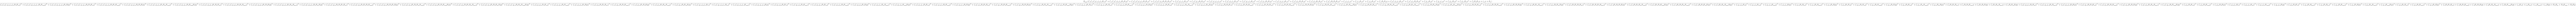

In [8]:
H_sym = (U_sym[v2]/U_sym[v8]).simplify()
H_sym

As shown above the symbolic solution is long. The FACTS method is supposed to reveal aspects of the circuit operation that get hidden by the algebra. I think the Pi Filter with parasitic elements included is too complex. The FACTS method attempts to expose the poles and zeros in terms of the network components. It is possible that some simplification could be done and a more meaningful analyis could be performed. 

The numerator and denominator of the transfer function can be extracted for analysis. 

In [9]:
n, d = fraction(H_sym)
display('numerator', n, 'denominator', d)

'numerator'

'denominator'

Solve for the roots of the numerator.

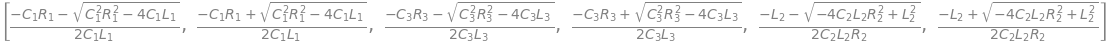

In [10]:
solve(n,s)

We can see that there are six zeros in the transfer function. Here can see what components are influncing the zeros. One of the gaols of the FACTS method was to determine the zeros of the network and express them in terms of the components.

Solve for the roots of the denominator

In [11]:
#solve(d,s)

SymPy could not find a solution for roots of denominator.

### Use numerical values for components

Built a dictionary of element values. The LTSpice schematic had all the component values set to one.

In [12]:
element_values = SymMNA.get_part_values(network_df)
element_values

In this analysis, we are going to assum that the circuit is a low pass filter and the parasitics component values are scalled by 1000 from the value of the main components.

In [13]:
# the values of the main components 
Ca = 1 
Cb = 1
La = 2
sf = 1e3 # parasitic scale factor

element_values[R1] = Ca/sf
element_values[Ra] = La/sf
element_values[R2] = La*sf
element_values[R3] = Cb/sf

element_values[L1] = Ca/sf
element_values[L2] = La
element_values[L3] = Cb/sf
element_values[C1] = Ca
element_values[C2] = La/sf
element_values[C3] = Cb

element_values

### Numerical solution

In [15]:
NE = NE_sym.subs(element_values)
NE

⎡                1501.0⋅v₁ - 500.0⋅v₃ - 1000.0⋅v₄ - v₈                ⎤   ⎡ 0 
⎢                                                                     ⎥   ⎢   
⎢-I_L2 + v₂⋅(0.002⋅s + 1001.0005) + v₃⋅(-0.002⋅s - 0.0005) - 1000.0⋅v₆⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢ I_L2 - 500.0⋅v₁ + v₂⋅(-0.002⋅s - 0.0005) + v₃⋅(0.002⋅s + 500.0005)  ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢                    I_L1 - 1000.0⋅v₁ + 1000.0⋅v₄                     ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢                            -I_L1 + s⋅v₅                             ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢                    I_L3 - 1000.0⋅v₂ + 1000.0⋅v₆                     ⎥   ⎢ 0 
⎢                                                                     ⎥ = ⎢   
⎢                            -I_L3 + s⋅v₇           

In [16]:
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = \frac{2004.0 s^{6} + 1008509.0 s^{5} + 1006517006.0 s^{4} + 3012013501.0 s^{3} + 1005009503000.0 s^{2} + 1002503000000.0 s + 501000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$v_{2} = \frac{2000.0 s^{6} + 4500.0 s^{5} + 4503000.0 s^{4} + 6000500.0 s^{3} + 3001500000.0 s^{2} + 1500000000.0 s + 500000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$v_{3} = \frac{2000.0 s^{6} + 1004500.0 s^{5} + 1006503000.0 s^{4} + 3007000500.0 s^{3} + 1005001500000.0 s^{2} + 1001500000000.0 s + 500000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$v_{4} = \frac{2004.0 s^{6} + 1006505.0 s^{5} + 1005510501.0 s^{4} + 2008507000.0 s^{3} + 1004007501000.0 s^{2} + 1002002000000.0 s + 501000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$v_{5} = \frac{2004000.0 s^{4} + 1006505000.0 s^{3} + 1003506501000.0 s^{2} + 1002002000000.0 s + 501000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$v_{6} = \frac{2000.0 s^{6} + 2500.0 s^{5} + 4500500.0 s^{4} + 3500000.0 s^{3} + 3000500000.0 s^{2} + 1000000000.0 s + 500000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$v_{7} = \frac{2000000.0 s^{4} + 2500000.0 s^{3} + 2500500000.0 s^{2} + 1000000000.0 s + 500000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$v_{8} = 1.0$<br>$I_{V1} = \frac{- 2000.0 s^{6} - 4008500.0 s^{5} - 1013508000.0 s^{4} - 1006013001500.0 s^{3} - 1006003500000.0 s^{2} - 1002500000000.0 s - 500000000000.0}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$I_{L1} = \frac{2004000.0 s^{5} + 1006505000.0 s^{4} + 1003506501000.0 s^{3} + 1002002000000.0 s^{2} + 501000000000.0 s}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>$I_{L2} = \frac{500000.0 s^{2} + 500000.0 s + 500000000.0}{4004.0 s^{4} + 1009005.0 s^{3} + 1006007001.0 s^{2} + 1003002000.0 s + 1001000000.0}$<br>$I_{L3} = \frac{2000000.0 s^{5} + 2500000.0 s^{4} + 2500500000.0 s^{3} + 1000000000.0 s^{2} + 500000000000.0 s}{4004.0 s^{6} + 5017009.0 s^{5} + 2020025006.0 s^{4} + 1009025015001.0 s^{3} + 2011013003000.0 s^{2} + 2005003000000.0 s + 1001000000000.0}$<br>

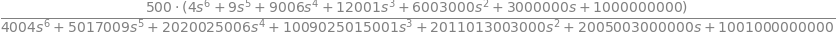

In [17]:
H = (U[v2]/U[v8]).nsimplify().simplify().expand().together()
H

The code below converst the SymPy equations into NumPy format. Extract the numerator and denominator polynomials so that the system can be defined in SciPy.

In [18]:
H_num, H_denom = fraction(H) #returns numerator and denominator

The SciPy function, TransferFunction, represents the system as the continuous-time transfer function and takes as inputs the coeeficients of the numerator and denominator polynominals.

In [19]:
# convert symbolic to NumPy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys = signal.TransferFunction(a,b)

### Poles and zeros of the low pass transfer function
The poles and zeros of the transfer function can easly be obtained and plotted with the following code:

In [21]:
sys_zeros = np.roots(sys.num)
sys_poles = np.roots(sys.den)

# plot the poles and zeros
plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
#plt.ylim((-2,2))
#plt.xlim((-4,0))
plt.grid()
plt.show()

Printing the value of the poles and zeros in radians per second.

In [22]:
print('number of zeros: {:d}'.format(len(sys_zeros)))
for i in sys_zeros:
    print('{:,.3f} rad/s'.format(i))

number of zeros: 6
-0.500+31.619j rad/s
-0.500-31.619j rad/s
-0.500+31.619j rad/s
-0.500-31.619j rad/s
-0.125+15.811j rad/s
-0.125-15.811j rad/s


In [23]:
print('number of poles: {:d}'.format(len(sys_poles)))
for i in sys_poles:
    print('{:,.3f} rad/s'.format(i))

number of poles: 6
-1,000.000+0.000j rad/s
-125.501+485.024j rad/s
-125.501-485.024j rad/s
-1.000+0.000j rad/s
-0.499+0.865j rad/s
-0.499-0.865j rad/s


### Bode plot
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter. 

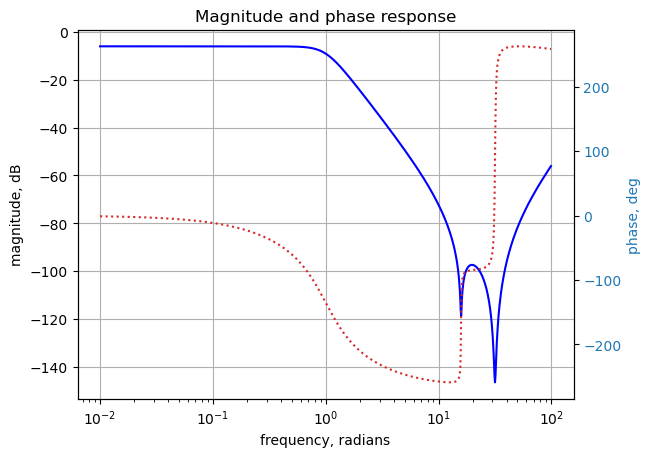

In [28]:
x = np.logspace(-2, 2, 1000, endpoint=False) #*2*np.pi
w, mag, phase = signal.bode(sys, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, radians')

plt.semilogx(w, mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w, phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

<!--
Write the impedances for each of the branches of the circuit.

Franc's answer walks through the FACTS method

### References

Methods of Design Oriented Analysis](https://www.scribd.com/document/422935307/Methods-of-design-oriented-analysis)

@Middlebrook1992, Methods of Design-Oriented Analysis: The Quadratic Equation Revisited

@Middlebrook1991, Low-entropy expressions: the key to design-oriented analysis

@basso2016, Introduction to Fast Analytical Techniques: Application to Small-Signal Modeling

<!--
Methods of DE~sign-Oriented Analysis: The Quadratic Equation Revisited
@INPROCEEDINGS{Middlebrook1992,
  author={Middlebrook, R.D.},
  booktitle={Proceedings. Twenty-Second Annual conference Frontiers in Education}, 
  title={Methods of Design-Oriented Analysis: The Quadratic Equation Revisited}, 
  year={1992},
  pages={95-102},
  doi={10.1109/FIE.1992.683365}
}

Low-entropy expressions: the key to design-oriented analysis
@INPROCEEDINGS{Middlebrook1991,
  author={Middlebrook, R.D.},
  booktitle={Proceedings Frontiers in Education Twenty-First Annual Conference. Engineering Education in a New World Order}, 
  title={Low-entropy expressions: the key to design-oriented analysis}, 
  year={1991},
  pages={399-403},
  doi={10.1109/FIE.1991.187513}
}

@online{basso2016,
    author = {Basso, Christophe},
    title = {Introduction to Fast Analytical Techniques: Application to Small-Signal Modeling},
    url  = {https://www.powersimtof.com/Downloads/PPTs/Chris%20Basso%20APEC%20seminar%202016.pdf},
    year={2016},
    addendum = {accessed 12 Feb 2024}
}


[Introduction to Fast Analytical Techniques: Application to Small-Signal Modeling](https://www.powersimtof.com/Downloads/PPTs/Chris%20Basso%20APEC%20seminar%202016.pdf)

-->

## Re-work of @user347817's solution
The solution provided by @user347817 is not a solution that following the FACTS method. He calculates the transfer function based on the ratio of the impedances of a voltage divider. @fig-pi-filter-franc, shows the orginal circuit re-drawn with the branches replaced by their transformed impedances.

![Pi filter schematic with branch impedances replaced by Z1, Z2 and Z3](Pi-Filter-franc.png){#fig-pi-filter-franc}  

The components for the branches are replace by Z1, Z2 and Z3.

```
Z1 = series connection of R1, L1 and C1

Z2 = series connection of Ra and (L2 || C2 || R2)

Z3 = series connection of R3, L3 and C3

Z4 = Z3 || R_out
```

The following defines the SymPy symbols used in the calculations. The function [symbols](https://docs.sympy.org/latest/tutorials/intro-tutorial/gotchas.html#symbols) takes a string of variable names separated by spaces or commas, and creates Symbols out of them.

In [29]:
L1, L2, L3, R1, R2, R3, Ra, R, R_out, R_in, C1, C2, C3, s, V1 = symbols('L1, L2, L3, R1, R2, R3, Ra, R, R_out, R_in, C1, C2, C3, s, V1')

### Branches of the circuit
Z1 is the series connection of R1, C1 and L1.

In [30]:
Z1_sym = R1+s*L1+1/(s*C1)
Z1_sym

Z2 is the series connection of Ra and the paralle connection of R2, L2 and C2

In [31]:
Z2_sym = (Ra+1/(1/(1/(s*C2)) + 1/(s*L2) + 1/R2))
Z2_sym

Z3 is the series connection of R3, L3 and C3

In [32]:
Z3_sym = R3+s*L3+1/(s*C3)
Z3_sym

Z4 is the parallel combination of R_out and Z3. 

Z4 = R_out || Z3

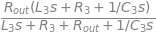

In [33]:
Z4_sym = R_out*Z3_sym/(R_out+Z3_sym)
Z4_sym

@user347817 provided a MatCAD like set of calculations. Using "||" to indicate a parallel combination of components and a "+" to indicate a series combination of componets, some of his calculations are shown here:  

$Z_1 = R_2 + sL_1 + \frac {1}{sC_1}$  
$Z_2 = R_6 + R_3 || sL_2 || \frac {1}{sC_2}$    
$Z_3 = R_4 + sL_3 + \frac {1}{sC_3}$  
$Z_4 = Z_3 || R_2$  

$V_1 = \frac {(Z_1 || (Z_2+Z_4))} {(R_1+Z_1 || (Z_2+Z_4))} V_i$  

$V_o = \frac {Z_4} {(Z_4+Z_2)} V_1$

$V_o = \frac {Z_4} {(Z_4+Z_2)} \frac {(Z_1 || (Z_2+Z_4))} {(R_1+Z_1 || (Z_2+Z_4))} V_i$ 

In [34]:
Z1, Z2, Z3, Z4, R_in, R_out, V1 = symbols('Z1, Z2, Z3, Z4, R_in, R_out, V1')

Zx is the parallel combination of Z1, Z2 and Z4.

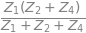

In [35]:
Zx = Z1*(Z2+Z4)/(Z1+Z2+Z4)
Zx

The voltage at node 1 is calculated by using the voltage divider formula for Zx and Rin.

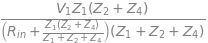

In [36]:
v_node1 = V1*Zx/(R_in+Zx)
v_node1

Vout is the voltage divider of Z2 and Z4.

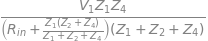

In [37]:
V_out =  v_node1*Z4/(Z2+Z4)
V_out

The trasfer function is Vout/Vin.
H_franc_sym

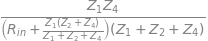

In [38]:
H_franc_z = V_out/V1
H_franc_z

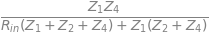

In [39]:
H_franc_z.simplify()

Repeating the calculations from above, but using symbolic expressions for Z1, Z2, Z3 and Z4.

Zx is the combination of Z's looking towards the output of the filter.
Zx = Z1 || (Z2+Z4)

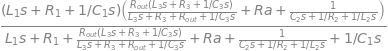

In [40]:
Zx_sym = Z1_sym*(Z2_sym+Z4_sym)/(Z1_sym+Z2_sym+Z4_sym)
Zx_sym

The voltage at node 1 is
```
v_node1 = V1*Zx/(R_in+Zx)
```

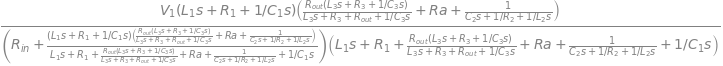

In [41]:
v_node1_sym = V1*Zx_sym/(R_in+Zx_sym)
v_node1_sym

V_out is the output of the voltage divider circuit formed by Z2 and Z4

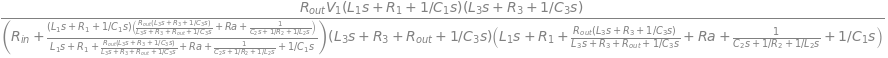

In [42]:
V_out_sym =  v_node1_sym*Z4_sym/(Z2_sym+Z4_sym)
V_out_sym

### H_franc_sym
The transfer function as determined by taking the impedance of branches and combining by series and parallel combinations can be expressed below.

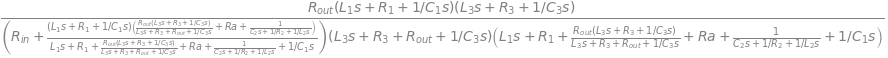

In [43]:
H_franc_sym = V_out_sym/V1
H_franc_sym

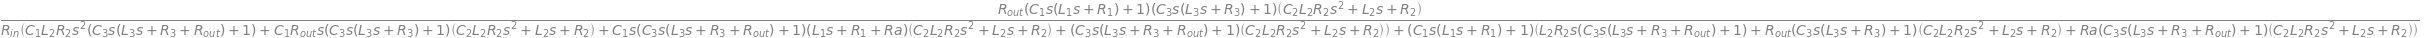

In [44]:
H_franc_sym_1a = H_franc_sym.simplify()
H_franc_sym_1a

In [45]:
n, d = fraction(H_franc_sym_1a)
display('numerator', n, 'denominator', d)

'numerator'

'denominator'

Solve for the roots of the numberator.

In [46]:
n.simplify().expand()

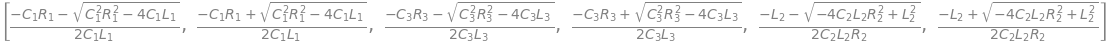

In [47]:
solve(n.simplify().expand(),s)

We can see that there are six zeros in the transfer function. Here can see what components are influncing the zeros. Once of the gaols of the FACTS method was to determine the zeros of the network.

Solve for the roots of the denominator

In [48]:
d.simplify().expand().together()
#d.simplify().expand()

In [49]:
#solve(d,s)

SymPy could not find a solution for roots of denominator.

### Use numerical values for components
The element vaules can be put into the equation.

In [50]:
element_values

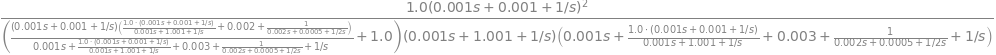

In [51]:
H_franc = H_franc_sym.subs(element_values)
H_franc

Simplifying the expression.

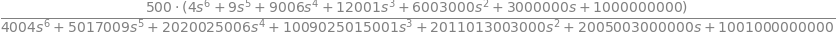

In [52]:
H_franc = H_franc.nsimplify().simplify().expand().together()
H_franc

### Poles and zeros of the low pass transfer function
The poles and zeros of the transfer function can easly be obtained with the following code:

In [55]:
H_franc_num, H_franc_denom = fraction(H_franc) #returns numerator and denominator

The SciPy function, TransferFunction, represents the system as the continuous-time transfer function and takes as inputs the coeeficients of the numerator and denominator polynominals.

In [56]:
# convert symbolic to NumPy polynomial
a = np.array(Poly(H_franc_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_franc_denom, s).all_coeffs(), dtype=float)
franc_sys = signal.TransferFunction(a,b)

In [57]:
franc_sys_zeros = np.roots(franc_sys.num)
franc_sys_poles = np.roots(franc_sys.den)

### Pole zero plot
The poles and zeros of the function are plotted on the complex plane.

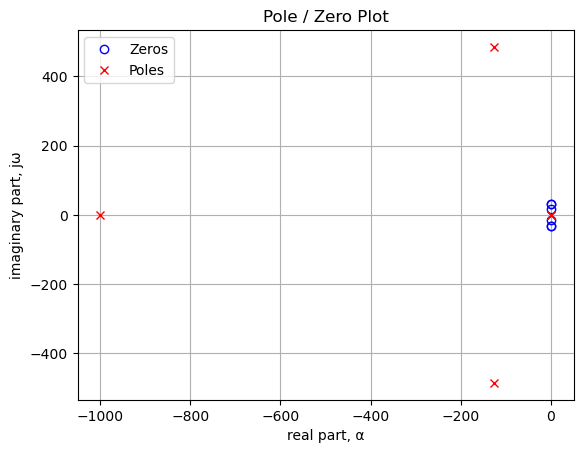

In [58]:
plt.plot(np.real(franc_sys_zeros), np.imag(franc_sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(franc_sys_poles), np.imag(franc_sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
#plt.ylim((-2,2))
#plt.xlim((-2,0))
plt.grid()
plt.show()

Printing the value of the poles and zeros in radians per second.

In [59]:
print('number of zeros: {:d}'.format(len(franc_sys_zeros)))
for i in franc_sys_zeros:
    print('{:,.3f} rad/s'.format(i))

number of zeros: 6
-0.500+31.619j rad/s
-0.500-31.619j rad/s
-0.500+31.619j rad/s
-0.500-31.619j rad/s
-0.125+15.811j rad/s
-0.125-15.811j rad/s


In [60]:
print('number of poles: {:d}'.format(len(franc_sys_poles)))
for i in franc_sys_poles:
    print('{:,.3f} rad/s'.format(i))

number of poles: 6
-1,000.000+0.000j rad/s
-125.501+485.024j rad/s
-125.501-485.024j rad/s
-1.000+0.000j rad/s
-0.499+0.865j rad/s
-0.499-0.865j rad/s


### Bode plot
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter. 

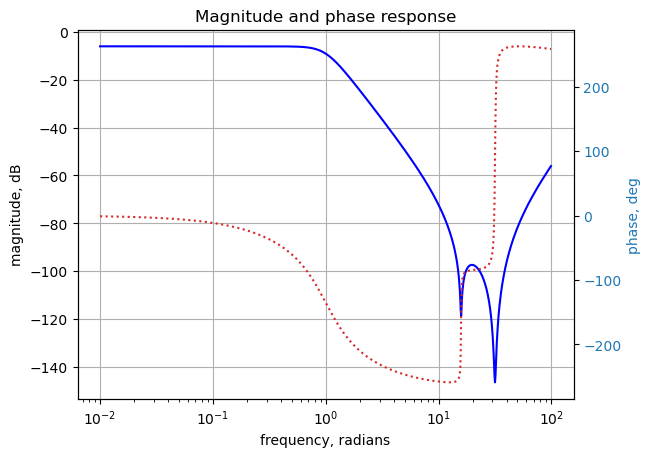

In [65]:
x = np.logspace(-2, 2, 1000, endpoint=False) #*2*np.pi
w_franc, mag_franc, phase_franc = signal.bode(franc_sys, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, radians')

plt.semilogx(w_franc, mag_franc,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w_franc, phase_franc,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

## Comapring solutions

Load the csv file from LTSpice.

In [66]:
fn = 'Pi-Filter-LTSpice.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
voltage = np.zeros(len(LTSpice_data)).astype(complex)

# convert the csv data to complez numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    voltage[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j

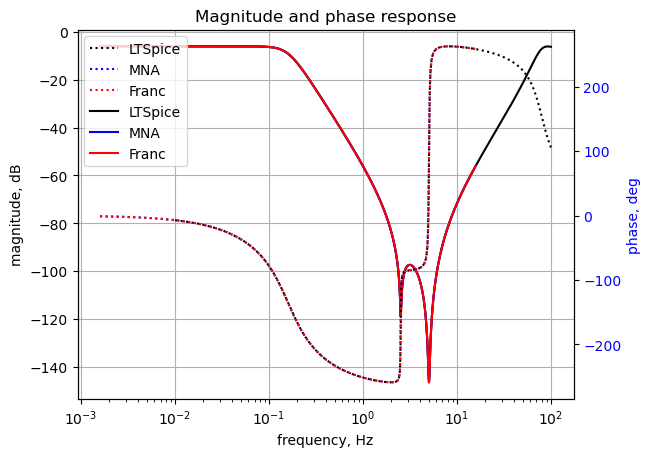

In [68]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(voltage)),'-k')    # LTSpice magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-b')    # MNA magnitude plot
plt.semilogx(w_franc/(2*np.pi), mag_franc,'-r')    # FACTS magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'b'

plt.semilogx(frequency, np.unwrap(2*np.angle(voltage)/2) *180/np.pi,':',color='k',label='LTSpice')  # LTSpice phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='b',label='MNA')  # MNA phase plot
plt.semilogx(w_franc/(2*np.pi), phase_franc,':',color='r',label='Franc')  # FACTS phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

ax2.plot(np.NaN, np.NaN, color='k', label='LTSpice')
ax2.plot(np.NaN, np.NaN, color='b', label='MNA')
ax2.plot(np.NaN, np.NaN, color='r', label='Franc')

plt.legend()
plt.title('Magnitude and phase response')
plt.show()

LTSpice, SMNA and Franc results agree. 

## Community answers
Both comunity answers did not provide a solution based on the FACTS method. Missing was the steps to extract the time constants of the circuit and from there find the zeros of the network. 

The answer from @user347817 replaces each leg of the filter with Z's and then uses series and parallel equalivent conbinations. As shown above this analysis provides only an approximate solution and probably would not cut the mustard in an acedemic or critical design reviwe.  

The answer provided by Tesla23 is also suspect and seems wrong. The following calculations walk through some of his steps.

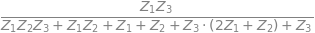

In [69]:
H_telsa23 = ((R*Z1*Z3)/(R*((Z2+2*Z1)*Z3 + Z1*Z2) + R**2*(Z3+Z2+Z1) + Z1*Z2*Z3)).subs({R:1})
H_telsa23

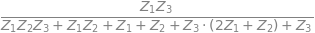

In [70]:
H_telsa23.simplify()

Comparing the results above to my rendition of FACTS, you can see that they are not the same.

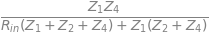

In [72]:
H_franc_z.simplify()

It's not worth my time to analyze Tesla23's answer to determine why there is a difference, especially since the thrust of these notebooks is MNA.

## Reduced complexity circuit with source and load impedance
The following analysis finds the transfer function for the circuit below. The parasitic components have been removed from the schematic. The circuit is now a third order circuit. As shown below the poles of the transferfunction expressed symbolically are long and complex. It's hard to see how a FACTS solution would yield design oriented results. 

![Pi filter with out parasitics](Pi-Filter-FACTS-Simplified.png){#fig-pi-filter-simplified}  


In [73]:
net_list = '''
V1 3 0 1
R_in 1 3 1
R_out 2 0 1
C1 1 0 1
C2 2 0 1
L1 1 2 1
'''

### Call the symbolic modified nodal analysis function


In [74]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The network equations for the circuit can be obtained from the A, X and Z values returned from the smna function. The A, X and Z are formulated into equations and displayed below. Markdown is an IPython function and latex is a SymPy printing function.

In [75]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$I_{L1} + v_{1} \left(C_{1} s + \frac{1}{R_{in}}\right) - \frac{v_{3}}{R_{in}} = 0$<br>$- I_{L1} + v_{2} \left(C_{2} s + \frac{1}{R_{out}}\right) = 0$<br>$I_{V1} - \frac{v_{1}}{R_{in}} + \frac{v_{3}}{R_{in}} = 0$<br>$v_{3} = V_{1}$<br>$- I_{L1} L_{1} s + v_{1} - v_{2} = 0$<br>

### Build the network equation matrix

In [76]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡          ⎛        1 ⎞    v₃⎤       
⎢I_L1 + v₁⋅⎜C₁⋅s + ───⎟ - ───⎥       
⎢          ⎝       Rᵢₙ⎠   Rᵢₙ⎥       
⎢                            ⎥   ⎡0 ⎤
⎢             ⎛        1  ⎞  ⎥   ⎢  ⎥
⎢  -I_L1 + v₂⋅⎜C₂⋅s + ────⎟  ⎥   ⎢0 ⎥
⎢             ⎝       Rₒᵤₜ⎠  ⎥   ⎢  ⎥
⎢                            ⎥ = ⎢0 ⎥
⎢              v₁    v₃      ⎥   ⎢  ⎥
⎢      I_V1 - ─── + ───      ⎥   ⎢V₁⎥
⎢             Rᵢₙ   Rᵢₙ      ⎥   ⎢  ⎥
⎢                            ⎥   ⎣0 ⎦
⎢             v₃             ⎥       
⎢                            ⎥       
⎣    -I_L1⋅L₁⋅s + v₁ - v₂    ⎦       

In [77]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

### Symbolic solution
The network equations can be solved symbolically. 

In [78]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [79]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{C_{2} L_{1} R_{out} V_{1} s^{2} + L_{1} V_{1} s + R_{out} V_{1}}{C_{1} C_{2} L_{1} R_{in} R_{out} s^{3} + C_{1} L_{1} R_{in} s^{2} + C_{1} R_{in} R_{out} s + C_{2} L_{1} R_{out} s^{2} + C_{2} R_{in} R_{out} s + L_{1} s + R_{in} + R_{out}}$<br>$v_{2} = \frac{R_{out} V_{1}}{C_{1} C_{2} L_{1} R_{in} R_{out} s^{3} + C_{1} L_{1} R_{in} s^{2} + C_{1} R_{in} R_{out} s + C_{2} L_{1} R_{out} s^{2} + C_{2} R_{in} R_{out} s + L_{1} s + R_{in} + R_{out}}$<br>$v_{3} = V_{1}$<br>$I_{V1} = \frac{- C_{1} C_{2} L_{1} R_{out} V_{1} s^{3} - C_{1} L_{1} V_{1} s^{2} - C_{1} R_{out} V_{1} s - C_{2} R_{out} V_{1} s - V_{1}}{C_{1} C_{2} L_{1} R_{in} R_{out} s^{3} + C_{1} L_{1} R_{in} s^{2} + C_{1} R_{in} R_{out} s + C_{2} L_{1} R_{out} s^{2} + C_{2} R_{in} R_{out} s + L_{1} s + R_{in} + R_{out}}$<br>$I_{L1} = \frac{C_{2} R_{out} V_{1} s + V_{1}}{C_{1} C_{2} L_{1} R_{in} R_{out} s^{3} + C_{1} L_{1} R_{in} s^{2} + C_{1} R_{in} R_{out} s + C_{2} L_{1} R_{out} s^{2} + C_{2} R_{in} R_{out} s + L_{1} s + R_{in} + R_{out}}$<br>

### Transfer function

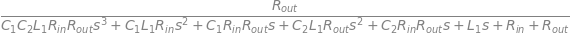

In [80]:
H_sym_1  = (U_sym[v2]/U_sym[v3]).simplify()
H_sym_1

In [81]:
n, d = fraction(H_sym_1)
display('numerator', n, 'denominator', d)

'numerator'

'denominator'

Solve for the roots of the denominator

In [84]:
d.simplify().expand().together()
#d.simplify().expand()

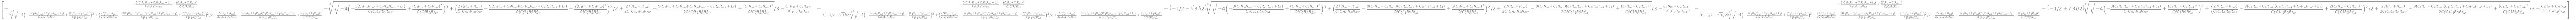

In [85]:
solve(d,s)

## Summary

- FACTS method is applicable to low order circuits
- The assurtion that brute force is complicated and error prone is not true if computer algebra tools are used. The same proported advantages of using FACTS, that is, less math, less algebra and some insight into the circuit operation are available with SMNA, since the computer does all the heavy lifting.
- Python based symbolic MNA code provides an easy and less error prone method of obtaining solutions to network problems. 

<!--

In [91]:
stop

NameError: name 'stop' is not defined

## Using Easy method
simple substitution

```
* C:\users\jeff64\My Documents\Solving Electrical Engineering Problems with Python Blog\MNA Problem Circuits\Pi-filter\Pi-Filter-FACTS.asc
V1 3 0 1
R_in 1 3 1
R_out 2 0 1
R§Z1 1 0 Series R1, L1 & C1
R§Z2 2 1 Series Ra & (L2 || C2 || R2)
R§Z3 2 0 Series R3, L3 & C3
.op
.backanno
.end
```

In [ ]:
net_list = '''
V1 3 0 1
R_in 1 3 1
R_out 2 0 1
R1 1 0 1
R2 2 1 1
R3 2 0 1
'''

## Call the symbolic modified nodal analysis function


In [ ]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The network equations for the circuit can be obtained from the A, X and Z values returned from the smna function. The A, X and Z are formulated into equations and displayed below. Markdown is an IPython function and latex is a SymPy printing function.

In [ ]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

### Build the network equation matrix

In [ ]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

In [ ]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution
The network equations can be solved symbolically. 

In [ ]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [ ]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

## Transfer function

In [ ]:
U_sym[v2]/U_sym[v3]

In [ ]:
H_sym_1  = (U_sym[v2]/U_sym[v3]).simplify()
H_sym_1

Substitue 

In [ ]:
Z1_sym

In [ ]:
Z2_sym

In [ ]:
Z3_sym

In [ ]:
H_sym_1a = H_sym_1.subs({R1:Z1_sym,R2:Z2_sym,R3:Z3_sym})
H_sym_1a

In [ ]:
H_sym_1a.simplify()

In [ ]:
H_1a = H_sym_1a.subs({V1: 1.0, R_in: 1.0, R1: 0.001, Ra: 0.002, R2: 2000.0, R3: 0.001, R_out: 1.0, L1: 0.001, L2: 2, L3: 0.001, C1: 1, C2: 0.002, C3: 1})
H_1a

In [ ]:
H_1a = H_1a.nsimplify().simplify().expand().together()
H_1a

In [ ]:
H_1a_num, H_1a_denom = fraction(H_1a) #returns numerator and denominator

# convert symbolic to NumPy polynomial
H_1a_a = np.array(Poly(H_1a_num, s).all_coeffs(), dtype=float)
H_1a_b = np.array(Poly(H_1a_denom, s).all_coeffs(), dtype=float)
H_1a_sys = signal.TransferFunction(H_1a_a,H_1a_b)
H_1a_w, H_1a_mag, H_1a_phase = signal.bode(H_1a_sys, w=x) # returns: rad/s, mag in dB, phase in deg

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(voltage)),'-k')    # LTSpice magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-b')    # MNA magnitude plot
plt.semilogx(w_franc/(2*np.pi), mag_franc,'-r')    # Franc magnitude plot
plt.semilogx(H_1a_w/(2*np.pi), H_1a_mag,'-g')    # easy magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'b'

plt.semilogx(frequency, np.unwrap(2*np.angle(voltage)/2) *180/np.pi,':',color='k',label='LTSpice')  # LTSpice phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='b',label='MNA')  # MNA phase plot
plt.semilogx(w_franc/(2*np.pi), phase_franc,':',color='r',label='Franc')  # Franc phase plot
plt.semilogx(H_1a_w/(2*np.pi), H_1a_phase,':',color='g',label='easy')  # easy phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

ax2.plot(np.NaN, np.NaN, color='k', label='LTSpice')
ax2.plot(np.NaN, np.NaN, color='b', label='MNA')
ax2.plot(np.NaN, np.NaN, color='r', label='FACTS')
ax2.plot(np.NaN, np.NaN, color='g', label='easy')

plt.legend()
plt.title('Magnitude and phase response')
plt.show()

In [ ]:
H

In [ ]:
H_facts

In [ ]:
H_1a

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(voltage)),'-k')    # LTSpice magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-b')    # MNA magnitude plot
plt.semilogx(w_franc/(2*np.pi), mag_franc,'-r')    # FACTS magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'b'

plt.semilogx(frequency, np.unwrap(2*np.angle(voltage)/2) *180/np.pi,':',color='k',label='LTSpice')  # LTSpice phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='b',label='MNA')  # MNA phase plot
plt.semilogx(w_franc/(2*np.pi), phase_franc,':',color='r',label='Franc')  # FACTS phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

ax2.plot(np.NaN, np.NaN, color='k', label='LTSpice')
ax2.plot(np.NaN, np.NaN, color='b', label='MNA')
ax2.plot(np.NaN, np.NaN, color='r', label='Franc')

plt.legend()
plt.title('Magnitude and phase response')
plt.show()

## Z1
```
V1 1 0 1 AC 1
R1 1 2 1
L1 2 3 1 Rser=0
C1 3 0 1
```

In [ ]:
net_list = '''
V1 1 0 1
R1 1 2 1
L1 2 3 1
C1 3 0 1
'''

## Call the symbolic modified nodal analysis function


In [ ]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The network equations for the circuit can be obtained from the A, X and Z values returned from the smna function. The A, X and Z are formulated into equations and displayed below. Markdown is an IPython function and latex is a SymPy printing function.

In [ ]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

### Build the network equation matrix

In [ ]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

In [ ]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution
The network equations can be solved symbolically. 

In [ ]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [ ]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

In [ ]:
U_sym

## Transfer function

In [ ]:
U_sym[v1]/U_sym[I_V1]

In [ ]:
(U_sym[v1]/U_sym[I_V1]).simplify()

In [ ]:
Z1_sym

## Z2
```
V1 1 0 1 AC 1
Ra 2 1 1
R2 0 2 1
L2 2 0 1 Rser=0
C2 0 2 1
```

In [ ]:
net_list = '''
V1 1 0 1
Ra 2 1 1
R2 0 2 1
L2 2 0 1
C2 0 2 1
'''

## Call the symbolic modified nodal analysis function


In [ ]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The network equations for the circuit can be obtained from the A, X and Z values returned from the smna function. The A, X and Z are formulated into equations and displayed below. Markdown is an IPython function and latex is a SymPy printing function.

In [ ]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

### Build the network equation matrix

In [ ]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

In [ ]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution
The network equations can be solved symbolically. 

In [ ]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [ ]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

In [ ]:
U_sym

## Transfer function

In [ ]:
U_sym[v1]/U_sym[I_V1]

In [ ]:
(U_sym[v1]/U_sym[I_V1]).simplify().expand().together()

In [ ]:
(U_sym[v1]/U_sym[I_V1]).simplify().expand().together()

In [ ]:
(-1*U_sym[v1]/U_sym[I_V1]).simplify().expand().together()

In [ ]:
Z2_sym

In [ ]:
Z2_sym.simplify().expand().together()

In [ ]:
(Ra+1/(1/(1/(s*C2)) + 1/(s*L2) + 1/R2)).simplify().expand().together()

## Z3
```
V1 1 0 1 AC 1
R3 1 2 1
L3 2 3 1 Rser=0
C3 3 0 1
```

In [ ]:
net_list = '''
V1 1 0 1
R3 1 2 1
L3 2 3 1
C3 3 0 1
'''

## Call the symbolic modified nodal analysis function


In [ ]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The network equations for the circuit can be obtained from the A, X and Z values returned from the smna function. The A, X and Z are formulated into equations and displayed below. Markdown is an IPython function and latex is a SymPy printing function.

In [ ]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

### Build the network equation matrix

In [ ]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

In [ ]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution
The network equations can be solved symbolically. 

In [ ]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [ ]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

In [ ]:
U_sym

## Transfer function

In [ ]:
U_sym[v1]/U_sym[I_V1]

In [ ]:
(U_sym[v1]/U_sym[I_V1]).simplify() #.expand().together()

In [ ]:
Z3_sym

In [ ]:
Z3_sym.simplify() #.expand().together()

# Reduced complexity circuit w/o R source and load
```
* C:\users\jeff64\My Documents\Solving Electrical Engineering Problems with Python Blog\MNA Problem Circuits\Pi-filter\Pi-Filter-FACTS-Simplified-wo-source-load-R.asc
V1 1 0 1 AC 1
C1 1 0 1
C2 2 0 2
L1 1 2 2
;op
.ac dec 1000 0.01 100
.backanno
.end

```

In [ ]:
net_list = '''
V1 1 0 1
C1 1 0 1
C2 2 0 1
L1 1 2 1
'''

## Call the symbolic modified nodal analysis function


In [ ]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The network equations for the circuit can be obtained from the A, X and Z values returned from the smna function. The A, X and Z are formulated into equations and displayed below. Markdown is an IPython function and latex is a SymPy printing function.

In [ ]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

### Build the network equation matrix

In [ ]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

In [ ]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution
The network equations can be solved symbolically. 

In [ ]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [ ]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

## Transfer function

In [ ]:
U_sym[v2]/U_sym[v1]

In [ ]:
H_sym_1  = (U_sym[v2]/U_sym[v1]).simplify()
H_sym_1

In [ ]:
n, d = fraction(H_sym_1)
display('numerator', n, 'denominator', d)

Solve for the roots of the numberator.

In [ ]:
n.simplify().expand()

In [ ]:
solve(n.simplify().expand(),s)

We can see that there are six zeros in the transfer function. Here can see what components are influncing the zeros. Once of the gaols of the FACTS method was to determine the zeros of the network.

Solve for the roots of the denominator

In [ ]:
d.simplify().expand().together()
#d.simplify().expand()

In [ ]:
solve(d,s)